# Demo: Instrument-Level Processing (Compact Workflow)

This notebook walks through the complete instrument-level processing pipeline in the oceanarray codebase, from raw files to science-ready datasets. It demonstrates the same processing steps as `demo_stage1.ipynb` and `demo_stage2.ipynb` but in a more compact, streamlined format.

## Processing Overview

### Stage 1: Format Conversion (`*_raw.nc`)
- **Purpose**: Convert raw instrument files to standardized NetCDF format
- **Input**: Raw instrument files (`.cnv`, `.rsk`, `.dat`, `.mat`)  
- **Output**: Standardized NetCDF files (`*_raw.nc`)
- **Processing**: Uses `oceanarray.stage1.MooringProcessor` - same as `demo_stage1.ipynb`

### Stage 2: Temporal Corrections & Trimming (`*_use.nc`)
- **Purpose**: Apply clock corrections and trim to deployment periods
- **Input**: Stage1 files (`*_raw.nc`) + updated YAML with clock offsets
- **Output**: Time-corrected files (`*_use.nc`)
- **Processing**: Uses `oceanarray.stage2.process_multiple_moorings_stage2` - same as `demo_stage2.ipynb`

### Stage 3: Calibrations & Corrections (Optional)
- **Purpose**: Apply sensor-specific calibrations and corrections
- **Status**: Commented out sections showing how to apply additional calibrations

### Stage 4: Format Conversion (Optional)
- **Purpose**: Convert to OceanSites or other standardized formats
- **Status**: Commented out sections for format conversion

## Key Features

- **Compact Format**: Covers the same ground as separate stage notebooks in one place
- **Instrument-Level Processing**: Each instrument processed independently before mooring-level coordination
- **Multiple Instrument Types**: Handles various instrument types with analysis functions
- **Visualization**: Includes plotting and analysis of processed results
- **Metadata Management**: YAML configuration files drive processing parameters

## Comparison with Other Notebooks

- **vs demo_stage1.ipynb**: Same Stage1 processing but more concise
- **vs demo_stage2.ipynb**: Same Stage2 processing but integrated workflow  
- **vs demo_step1.ipynb**: Focuses on individual instruments rather than mooring-level time gridding

Choose this notebook if you want a complete instrument processing workflow in one place, or use the separate stage notebooks for more detailed exploration of each processing step.

Version: 1.0  
Date: 2025-01-15

In [1]:
from pathlib import Path
from datetime import datetime

import os
import sys
import yaml
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from oceanarray.stage1 import MooringProcessor, process_multiple_moorings, stage1_mooring
from oceanarray import writers
from ctd_tools.readers import NortekAsciiReader, AdcpMatlabReader
from ctd_tools.plotters import TimeSeriesPlotter
from ctd_tools.writers import NetCdfWriter


/home/runner/micromamba/envs/TEST/lib/python3.13/site-packages/pycnv/pycnv.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Configuration
 
Set up the base directory and mooring lists for processing

In [2]:
# Base directory containing the mooring data
basedir = '../data/'

# Define mooring lists
single_test = ['dsE_1_2018']

# Choose which set to process
moorlist = single_test

print(f"Base directory: {basedir}")
print(f"Processing {len(moorlist)} moorings: {moorlist}")

Base directory: ../data/
Processing 1 moorings: ['dsE_1_2018']


## Stage 1: Load raw instrument files and convert to *_raw.nc


In [3]:
# Initialize the processor
processor = MooringProcessor(basedir)

# Process each mooring individually with detailed output
results = {}
for mooring_name in moorlist:
    print(f"\n{'='*60}")
    print(f"Processing mooring: {mooring_name}")
    print(f"{'='*60}")

    success = processor.process_mooring(mooring_name)
    results[mooring_name] = success

    status = "✅ SUCCESS" if success else "❌ FAILED"
    print(f"\nResult for {mooring_name}: {status}")

# Print final summary
print(f"\n{'='*60}")
print("FINAL PROCESSING SUMMARY")
print(f"{'='*60}")
successful = sum(results.values())
total = len(results)
print(f"Successfully processed: {successful}/{total} moorings")

for mooring, success in results.items():
    status = "✅" if success else "❌"
    print(f"{status} {mooring}")

INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606363_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606363_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606363_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe16/DSE18_sbe16_2419efw1.cnv


INFO:pycnv:Dates computed based on timeS



Processing mooring: dsE_1_2018
Processing mooring: dsE_1_2018
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606363_2018_08_27.cnv: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606363_2018_08_27.cnv'
Date
Computing date


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606401_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606401_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606401_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606402_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606402_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606402_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05608482_2018_08_27.cnv


EXCEPT: Error reading file moor/raw/msm76_2018/sbe16/DSE18_sbe16_2419efw1.cnv: Variable 'depth': Could not convert tuple of form (dims, data[, attrs, encoding]): (['time'], None) to Variable.
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606401_2018_08_27.cnv: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606401_2018_08_27.cnv'
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606402_2018_08_27.cnv: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606402_2018_08_27.cnv'


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606365_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606365_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606365_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606409_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606409_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606409_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606397_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606397_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606397_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606366_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606366_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606366_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606394_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606394_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606394_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606370_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606370_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606370_2018_08_27.cnv')


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/microcat/DSE18_SBE37SM_RS232_03707518_2018_08_26efw1.cnv


Date
Computing date
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05608482_2018_08_27.cnv: 'NoneType' object has no attribute 'strftime'
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606365_2018_08_27.cnv: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606365_2018_08_27.cnv'
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606409_2018_08_27.cnv: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606409_2018_08_27.cnv'
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606397_2018_08_27.cnv: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606397_2018_08_27.cnv'
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606366_2018_08_27.cnv: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606366_2018_08_27.cnv'
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606394_2018

INFO:pycnv:Dates computed based on start_date and time_interval


Date
Computing date


INFO:pycnv: Opening file: ../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606364_2018_08_27.cnv


CRITICAL:pycnv:Could not open file:../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606364_2018_08_27.cnv (Exception: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606364_2018_08_27.cnv')


-->   Processing microcat: moor/raw/msm76_2018/microcat/DSE18_SBE37SM_RS232_03707518_2018_08_26efw1.cnv
Creating output file: moor/proc/dsE_1_2018/microcat/dsE_1_2018_7518_raw.nc
Removing variable: potential_temperature
Removing variable: julian_days_offset
Removing variable: density
Removing coordinate: depth
Removing coordinate: latitude
Removing coordinate: longitude
EXCEPT: Error reading file moor/raw/msm76_2018/sbe56/DSE18_SBE05606364_2018_08_27.cnv: [Errno 2] No such file or directory: '../data/moor/raw/msm76_2018/sbe56/DSE18_SBE05606364_2018_08_27.cnv'
Completed processing: 1/23 instruments successful

Result for dsE_1_2018: ✅ SUCCESS

FINAL PROCESSING SUMMARY
Successfully processed: 1/1 moorings
✅ dsE_1_2018



Analyzing successful mooring: dsE_1_2018
Analyzing processed files in: ../data/moor/proc/dsE_1_2018/microcat
Found 1 NetCDF files:

📄 Loading: dsE_1_2018_7518_raw.nc
   Variables: ['temperature', 'salinity', 'conductivity', 'pressure', 'serial_number', 'InstrDepth', 'instrument', 'clock_offset', 'start_time', 'end_time']
   Attributes: ['latitude', 'longitude', 'CreateTime', 'DataType', 'mooring_name', 'waterdepth', 'deployment_latitude', 'deployment_longitude', 'deployment_time', 'seabed_latitude', 'seabed_longitude', 'recovery_time']
   Mooring: dsE_1_2018
   Instrument: microcat
   Serial: 7518


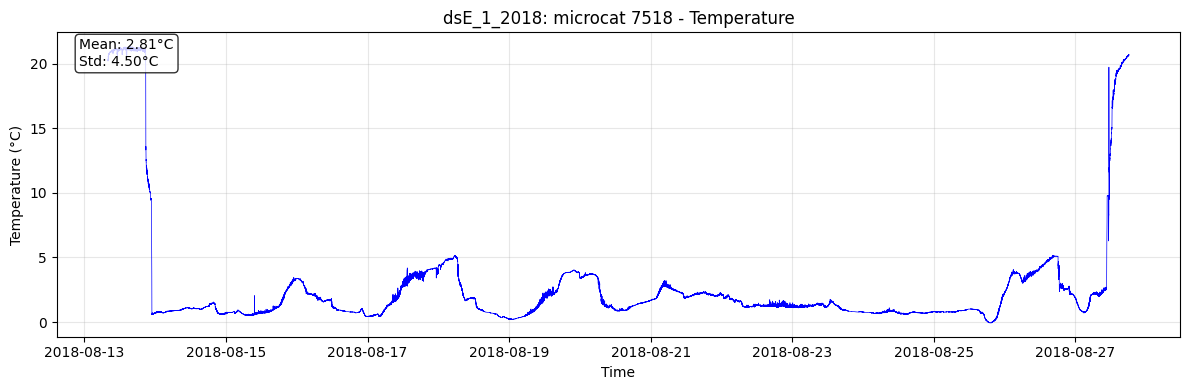

   📊 Plot saved: dsE_1_2018_microcat_7518_temperature_raw.png
Analyzing processed files in: ../data/moor/proc/dsE_1_2018/sbe16
No NetCDF files found
Analyzing processed files in: ../data/moor/proc/dsE_1_2018/sbe56
No NetCDF files found


In [4]:
# Analyze processed files
def analyze_processed_mooring(mooring_name, basedir, instrument_type='microcat'):
    """Analyze processed files for a specific mooring and instrument type."""
    proc_dir = Path(basedir) / 'moor/proc' / mooring_name / instrument_type
    fig_dir = proc_dir

    if not proc_dir.exists():
        print(f"Directory not found: {proc_dir}")
        return

    print(f"Analyzing processed files in: {proc_dir}")

    # Find all NetCDF files
    nc_files = list(proc_dir.glob('*raw.nc'))
    if not nc_files:
        print("No NetCDF files found")
        return

    print(f"Found {len(nc_files)} NetCDF files:")

    for file_path in nc_files:
        try:
            print(f"\n📄 Loading: {file_path.name}")

            with xr.open_dataset(file_path) as dataset:
                print(f"   Variables: {list(dataset.data_vars)}")
                print(f"   Attributes: {list(dataset.attrs.keys())}")

                # Extract key metadata
                mooring_name_attr = dataset.attrs.get('mooring_name', 'Unknown')
                instrument_name = dataset.get('instrument', 'Unknown').values if 'instrument' in dataset else 'Unknown'
                serial_number = dataset.get('serial_number', 0).values if 'serial_number' in dataset else 0

                print(f"   Mooring: {mooring_name_attr}")
                print(f"   Instrument: {instrument_name}")
                print(f"   Serial: {serial_number}")

                # Plot temperature if available
                if 'temperature' in dataset.data_vars:
                    fig, ax = plt.subplots(figsize=(12, 4))
                    ax.plot(dataset['time'], dataset['temperature'], 'b-', linewidth=0.5)
                    ax.set_ylabel('Temperature (°C)')
                    ax.set_title(f'{mooring_name_attr}: {instrument_name} {serial_number} - Temperature')
                    ax.set_xlabel('Time')
                    ax.grid(True, alpha=0.3)

                    # Add stats
                    temp_mean = dataset['temperature'].mean().values
                    temp_std = dataset['temperature'].std().values
                    ax.text(0.02, 0.98, f'Mean: {temp_mean:.2f}°C\nStd: {temp_std:.2f}°C',
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

                    plt.tight_layout()
                    plt.show()

                    # Save plot
                    plot_name = f"{mooring_name_attr}_{instrument_name}_{serial_number}_temperature_raw.png"
                    fig.savefig(fig_dir / plot_name, dpi=150, bbox_inches='tight')
                    print(f"   📊 Plot saved: {plot_name}")

        except Exception as e:
            print(f"   ❌ Error loading {file_path.name}: {e}")

# Example usage
if results and any(results.values()):
    # Analyze the first successfully processed mooring
    successful_mooring = next(mooring for mooring, success in results.items() if success)
    print(f"\nAnalyzing successful mooring: {successful_mooring}")
    analyze_processed_mooring(successful_mooring, basedir, 'microcat')
    analyze_processed_mooring(successful_mooring, basedir, 'sbe16')
    analyze_processed_mooring(successful_mooring, basedir, 'sbe56')
else:
    print("No successfully processed moorings to analyze")

## Stage 2: Trim to deployment period

In [5]:
from oceanarray.stage2 import Stage2Processor, process_multiple_moorings_stage2

results = process_multiple_moorings_stage2(moorlist, basedir)


Processing Stage 2 for mooring dsE_1_2018
Starting Stage 2 processing for mooring: dsE_1_2018
Deployment time: 2018-08-12T22:44:00.000000000
Recovery time: 2018-08-26T10:38:00.000000000
Processing microcat serial 7518
Applying clock offset: -2050 seconds
Trimming start to deployment time: 2018-08-12T22:44:00.000000000
Trimming end to recovery time: 2018-08-26T10:38:00.000000000
Trimmed from 124619 to 113473 records
Final time range: 2018-08-13T07:25:51.008000000 to 2018-08-26T10:37:50.979200000
Successfully wrote: ../data/moor/proc/dsE_1_2018/microcat/dsE_1_2018_7518_use.nc
Stage 2 completed: 1/23 instruments successful


## Stage 3: Apply calibrations + corrections

In [6]:
#ds_cal = process_rodb.apply_microcat_calibration_from_txt(data_dir / 'wb1_12_2015_005.microcat.txt', data_dir / 'wb1_12_2015_6123.use')
#ds_cal

In [7]:
#fig = plotters.plot_microcat(ds_cal)

In [8]:
#ds_diff = tools.calc_ds_difference(ds_cal, ds2)
#fig = plotters.plot_microcat(ds_diff)
#fig.suptitle("difference between *.use and *.microcat")

## Stage 4: Convert to OceanSites format


In [9]:
if 0:
    metadata_txt = data_dir / 'wb1_12_2015_6123.use'
    config_dir = Path("..") / "oceanarray" / "config"
    var_map_yaml = config_dir / "OS1_var_names.yaml"
    vocab_yaml = config_dir / "OS1_vocab_attrs.yaml"
    sensor_yaml = config_dir / "OS1_sensor_attrs.yaml"
    project_yaml = config_dir / "project_RAPID.yaml"
    ds_OS = convertOS.convert_rodb_to_oceansites(ds_cal, metadata_txt, var_map_yaml, vocab_yaml, sensor_yaml=sensor_yaml,project_yaml=project_yaml)
    ds_OS



In [10]:
if 0:
    filepath = writers.save_OS_instrument(ds_OS, basedir)
    print(filepath)